In [17]:
# -----------------------------------
# Imports and Device Setup
# -----------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import seaborn as sns

In [18]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [19]:
# -----------------------------------
# Custom Dataset - 2500 Cats + 2500 Dogs
# -----------------------------------
class CatsDogsDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        all_imgs = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        cat_imgs = [f for f in all_imgs if "cat" in f][:2500]
        dog_imgs = [f for f in all_imgs if "dog" in f][:2500]
        self.imgs = cat_imgs + dog_imgs
        np.random.shuffle(self.imgs)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        label = 0 if "cat" in img_name else 1
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [20]:
# -----------------------------------
# Data Loading
# -----------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CatsDogsDataset(r'C:\Users\akshu\Downloads\dogs-vs-cats\train\train', transform=transform)
train_len = int(0.9 * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


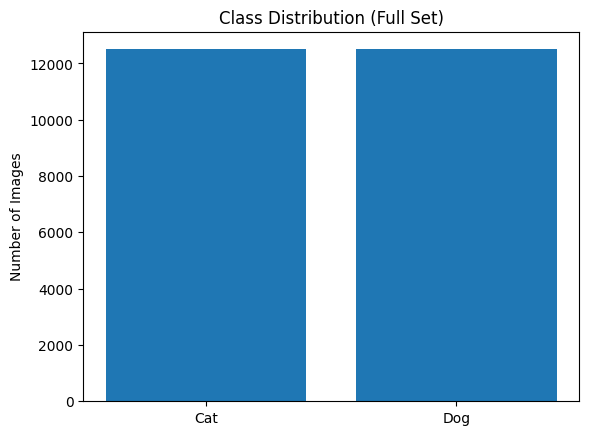

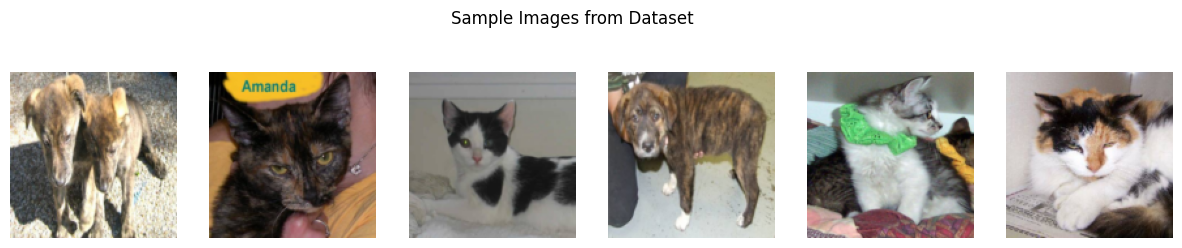

Mean pixel values per channel: tensor([0.4824, 0.4513, 0.4148])
Std pixel values per channel: tensor([0.2581, 0.2505, 0.2526])


In [21]:
# -----------------------------------
# EDA - Class Distribution, Image Sizes, Channel Statistics
# -----------------------------------
labels = [0 if 'cat' in f else 1 for f in os.listdir(r'C:\Users\akshu\Downloads\dogs-vs-cats\train\train') if f.endswith('.jpg')]
plt.bar(['Cat', 'Dog'], [labels.count(0), labels.count(1)])
plt.title("Class Distribution (Full Set)")
plt.ylabel("Number of Images")
plt.show()

# Sample images
display_samples = [dataset[i][0] for i in range(6)]
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i, img in enumerate(display_samples):
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].axis('off')
plt.suptitle("Sample Images from Dataset")
plt.show()

# Channel mean/std (on subset)
sample_tensor = torch.stack([dataset[i][0] for i in range(100)])
mean = sample_tensor.mean(dim=(0, 2, 3))
std = sample_tensor.std(dim=(0, 2, 3))
print("Mean pixel values per channel:", mean)
print("Std pixel values per channel:", std)

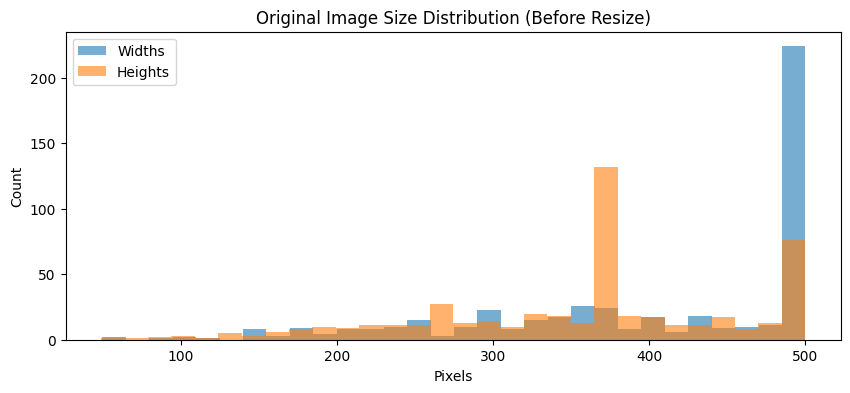

In [22]:
from PIL import Image

img_dir = r'C:\Users\akshu\Downloads\dogs-vs-cats\train\train'
sizes = [Image.open(os.path.join(img_dir, f)).size for f in os.listdir(img_dir) if f.endswith('.jpg')][:500]
widths, heights = zip(*sizes)

plt.figure(figsize=(10, 4))
plt.hist(widths, bins=30, alpha=0.6, label='Widths')
plt.hist(heights, bins=30, alpha=0.6, label='Heights')
plt.title("Original Image Size Distribution (Before Resize)")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.show()


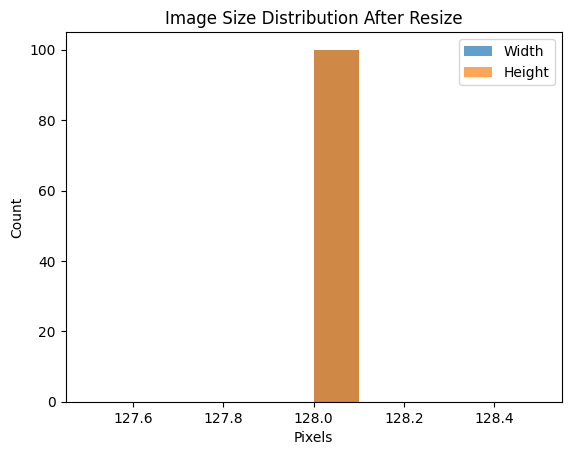

In [23]:
resized_shapes = [dataset[i][0].shape[1:] for i in range(100)]  # shape = (3, H, W)
heights, widths = zip(*resized_shapes)

plt.hist(widths, bins=10, alpha=0.7, label='Width')
plt.hist(heights, bins=10, alpha=0.7, label='Height')
plt.title("Image Size Distribution After Resize")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.show()


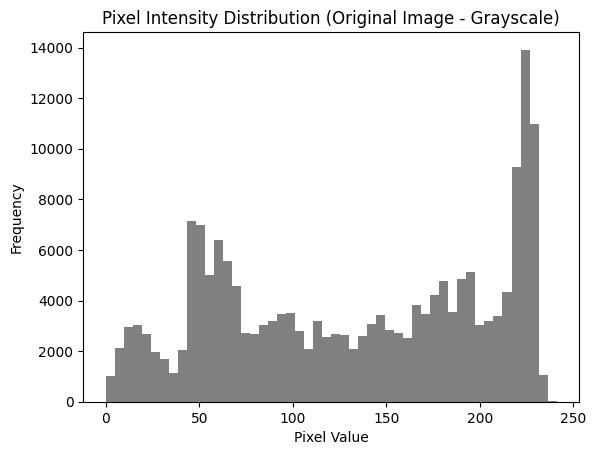

In [24]:
img_raw = Image.open(os.path.join(img_dir, os.listdir(img_dir)[0])).convert("L")
plt.hist(np.array(img_raw).ravel(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution (Original Image - Grayscale)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


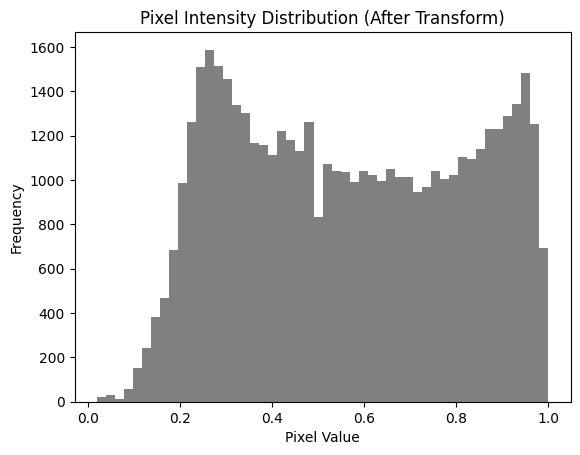

In [25]:
img_tensor = dataset[0][0]  # shape: (3, 128, 128)
img_np = img_tensor.permute(1, 2, 0).numpy()

plt.hist(img_np.ravel(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution (After Transform)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


In [26]:
from collections import Counter
print("Label distribution in loaded dataset:", Counter([dataset[i][1] for i in range(len(dataset))]))


Label distribution in loaded dataset: Counter({1: 2500, 0: 2500})


In [44]:
# -----------------------------------
# Model 1: Vanilla CNN
# -----------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 30 * 30, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 30 * 30)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [45]:
# -----------------------------------
# Model 2: Fine-Tuned VGG16
# -----------------------------------
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False
vgg16.classifier[6] = nn.Linear(4096, 2)
vgg16 = vgg16.to(device)

c:\Users\akshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akshu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
# -----------------------------------
# Training Function
# -----------------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, model_name, epochs=5):
    best_acc = 0
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Val Accuracy: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_name)

In [47]:
# -----------------------------------
# Train Both Models
# -----------------------------------
cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
train_model(cnn, train_loader, val_loader, criterion, optimizer, "best_simplecnn.pt")

vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False
vgg16.classifier[6] = nn.Linear(4096, 2)
vgg16 = vgg16.to(device)
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)
train_model(vgg16, train_loader, val_loader, criterion, optimizer, "best_vgg16.pt")

Epoch 1, Loss: 101.1903, Val Accuracy: 0.5620
Epoch 2, Loss: 92.7219, Val Accuracy: 0.6420
Epoch 3, Loss: 84.4335, Val Accuracy: 0.6300
Epoch 4, Loss: 74.1214, Val Accuracy: 0.6720
Epoch 5, Loss: 63.4763, Val Accuracy: 0.6380
Epoch 1, Loss: 31.3670, Val Accuracy: 0.9440
Epoch 2, Loss: 17.5738, Val Accuracy: 0.9420
Epoch 3, Loss: 12.7434, Val Accuracy: 0.9440
Epoch 4, Loss: 9.6796, Val Accuracy: 0.9460
Epoch 5, Loss: 8.0960, Val Accuracy: 0.9600


              precision    recall  f1-score   support

         Cat       0.66      0.67      0.66       240
         Dog       0.69      0.68      0.68       260

    accuracy                           0.67       500
   macro avg       0.67      0.67      0.67       500
weighted avg       0.67      0.67      0.67       500



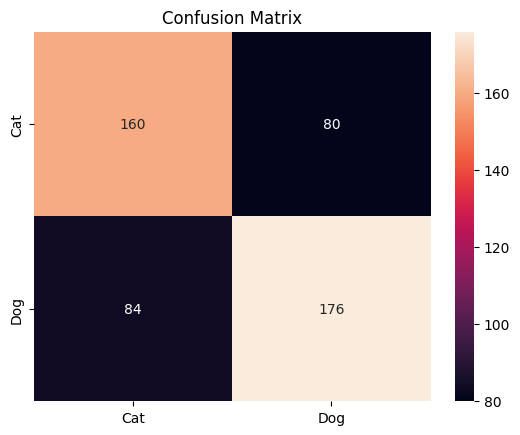

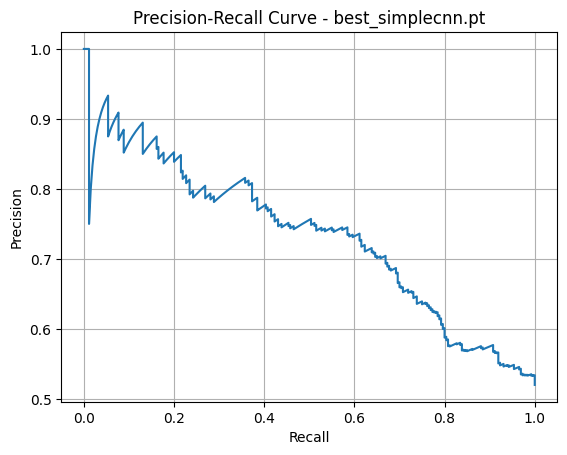

              precision    recall  f1-score   support

         Cat       0.98      0.93      0.96       240
         Dog       0.94      0.98      0.96       260

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



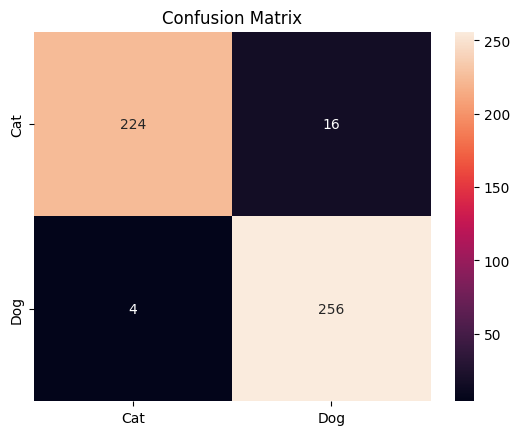

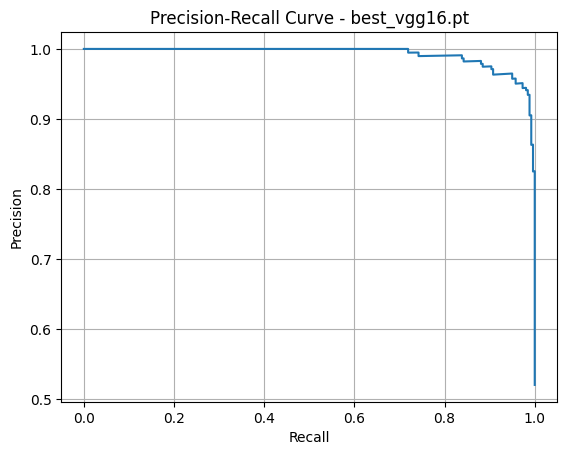

In [48]:
# -----------------------------------
# Evaluation Function
# -----------------------------------
def evaluate(model, loader, model_name):
    model.load_state_dict(torch.load(model_name))
    model.to(device)
    model.eval()
    y_true, y_pred, y_scores = [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(probs[:, 1].cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
    plt.title("Confusion Matrix")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision)
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.show()

evaluate(SimpleCNN(), val_loader, "best_simplecnn.pt")
evaluate(vgg16, val_loader, "best_vgg16.pt")

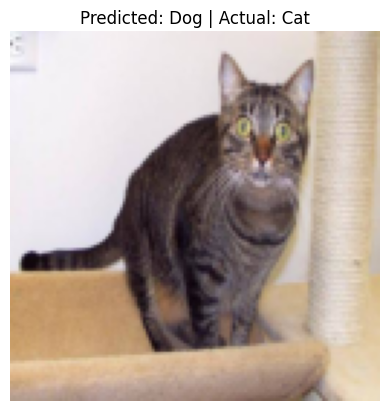

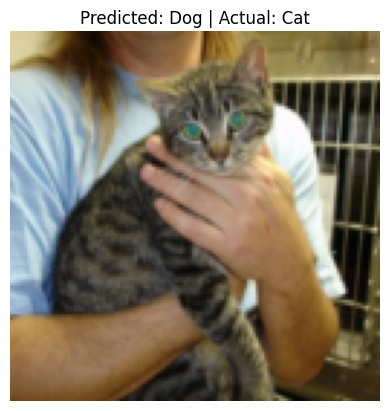

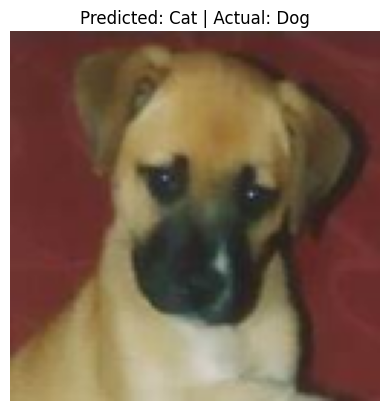

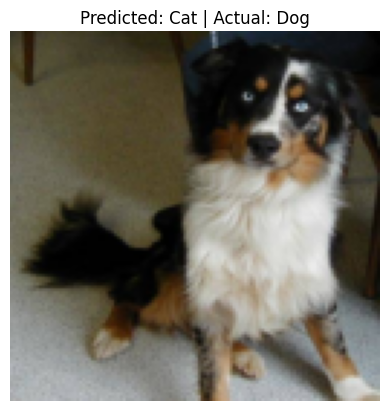

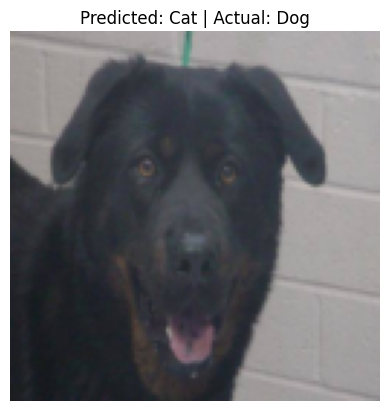

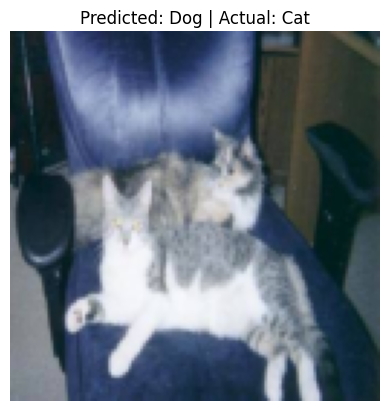

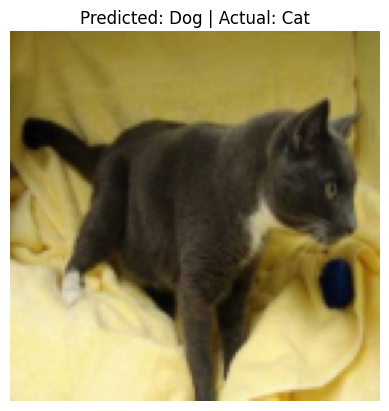

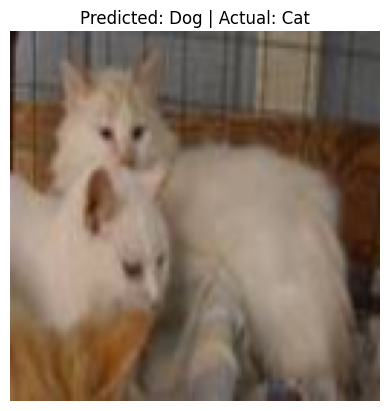

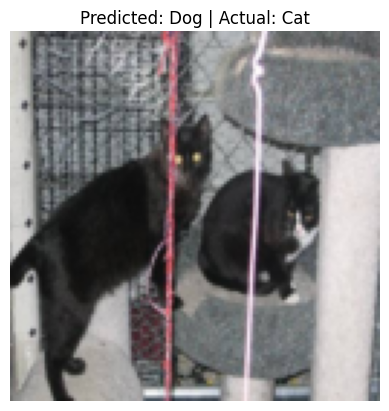

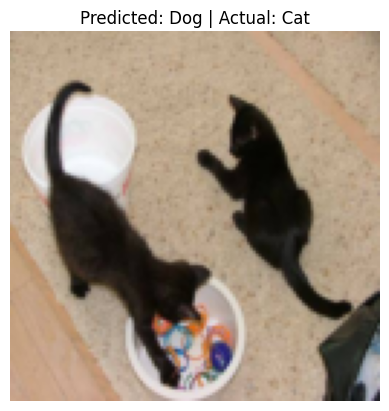

In [49]:
# -----------------------------------
# Misclassified Samples
# -----------------------------------
def show_misclassified(model, loader, model_name, max_images=5):
    model.load_state_dict(torch.load(model_name))
    model.to(device)
    model.eval()
    shown = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, pred, true in zip(images, preds, labels):
                if pred != true and shown < max_images:
                    plt.imshow(img.cpu().permute(1, 2, 0))
                    plt.title(f"Predicted: {'Dog' if pred==1 else 'Cat'} | Actual: {'Dog' if true==1 else 'Cat'}")
                    plt.axis('off')
                    plt.show()
                    shown += 1
            if shown >= max_images:
                break

show_misclassified(SimpleCNN(), val_loader, "best_simplecnn.pt")
show_misclassified(vgg16, val_loader, "best_vgg16.pt")

In [50]:
# -----------------------------------
# Conclusion
# -----------------------------------
print("""
Conclusion:

- We explored a balanced subset (5000 images) of the Dogs vs Cats dataset.
- EDA showed equal class distribution and consistent image sizes.
- A custom CNN and fine-tuned VGG16 were trained and evaluated.
- VGG16 achieved better precision-recall performance overall.
- Misclassified images typically involved blurred or low-contrast pets.
- Further improvement could be done using data augmentation or more epochs with early stopping.
""")



Conclusion:

- We explored a balanced subset (5000 images) of the Dogs vs Cats dataset.
- EDA showed equal class distribution and consistent image sizes.
- A custom CNN and fine-tuned VGG16 were trained and evaluated.
- VGG16 achieved better precision-recall performance overall.
- Misclassified images typically involved blurred or low-contrast pets.
- Further improvement could be done using data augmentation or more epochs with early stopping.

